<a href="https://colab.research.google.com/github/RevanthYalamanch/Project3/blob/main/mena_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

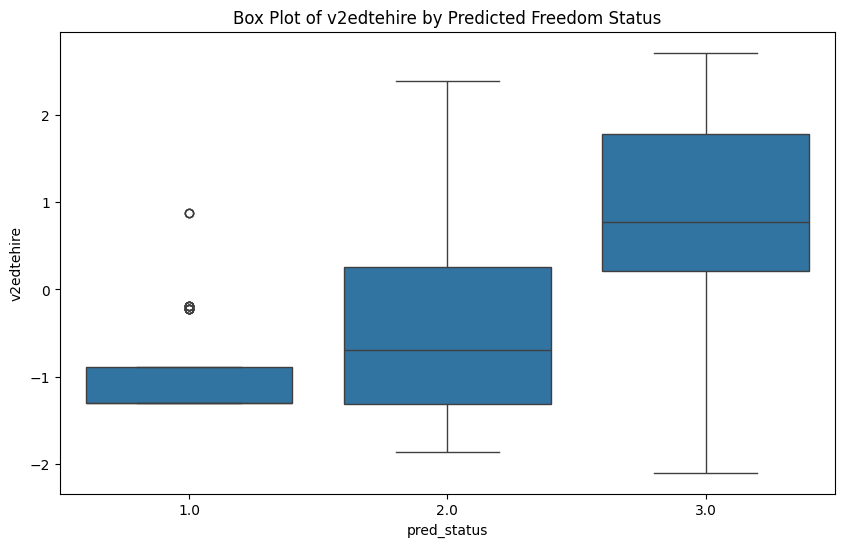


Summary Statistics for v2edtehire by Predicted Freedom Status:
             count      mean       std    min    25%    50%    75%    max
pred_status                                                              
1.0           90.0 -1.017456  0.524320 -1.303 -1.303 -1.303 -0.890  0.874
2.0          393.0 -0.472242  0.935599 -1.864 -1.314 -0.698  0.257  2.390
3.0          615.0  0.820146  1.123620 -2.097  0.213  0.769  1.779  2.713


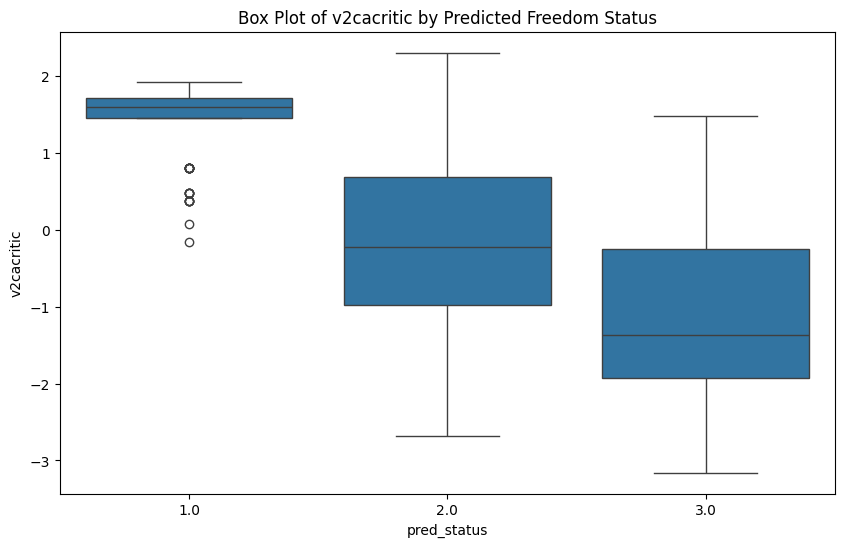


Summary Statistics for v2cacritic by Predicted Freedom Status:
             count      mean       std    min     25%     50%    75%    max
pred_status                                                                
1.0           92.0  1.390848  0.493314 -0.157  1.4590  1.5945  1.715  1.923
2.0          393.0 -0.214293  1.120505 -2.681 -0.9730 -0.2220  0.686  2.308
3.0          735.0 -1.194219  1.060802 -3.158 -1.9225 -1.3700 -0.246  1.485


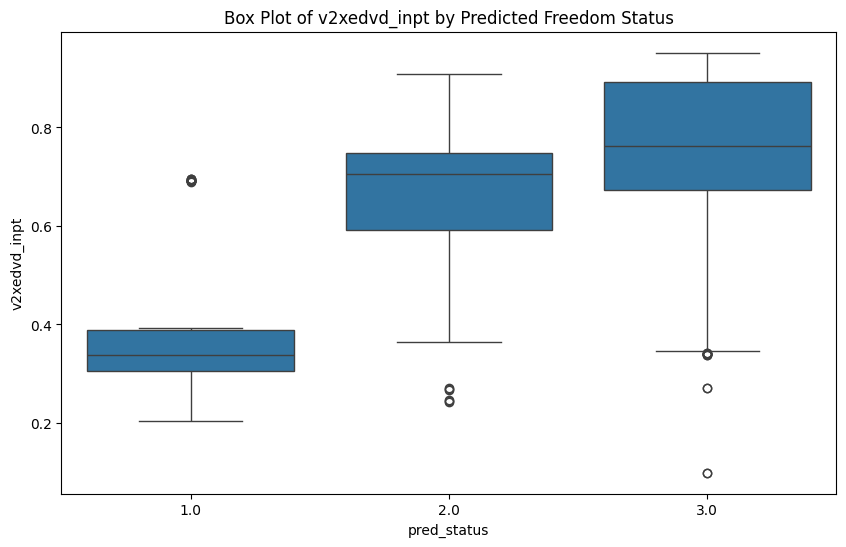


Summary Statistics for v2xedvd_inpt by Predicted Freedom Status:
             count      mean       std    min    25%    50%    75%    max
pred_status                                                              
1.0           90.0  0.383978  0.129183  0.203  0.306  0.337  0.389  0.696
2.0          393.0  0.679303  0.111738  0.243  0.592  0.705  0.749  0.908
3.0          615.0  0.747023  0.151219  0.099  0.672  0.762  0.892  0.952

ANOVA results for v2xedvd_inpt:
F-statistic: nan, p-value: nan


<ipython-input-1-0f60633341c6>:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_statistic, p_value = stats.f_oneway(free_data, partially_free_data, not_free_data)



Classification Report (with class weights):
              precision    recall  f1-score   support

         1.0       0.90      0.96      0.93        28
         2.0       0.86      0.89      0.87       122
         3.0       0.95      0.93      0.94       246

    accuracy                           0.92       396
   macro avg       0.91      0.93      0.92       396
weighted avg       0.92      0.92      0.92       396


Feature Importances from Random Forest:
v2xedvd_inpt    0.359078
v2cacritic      0.346559
v2edtehire      0.294363
dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


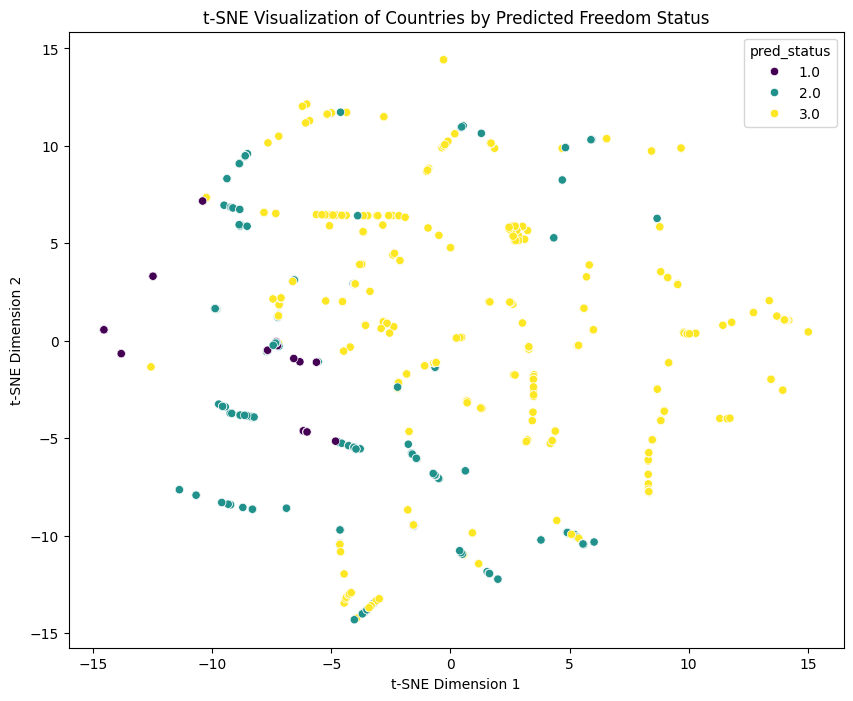

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# Load the dataset
df = pd.read_csv("mena_data.csv", low_memory=False)

# Encode 'pred_status' if needed for some analyses
status_mapping = {"Free": 1, "Partially Free": 2, "Not Free": 3} # If it's strings
# df['pred_status_encoded'] = df['pred_status'].map(status_mapping) # If it's strings

# 1. Individual Feature Exploration
features_to_explore = ['v2edtehire', 'v2cacritic','v2xedvd_inpt'] # Replace with your actual feature names

for feature in features_to_explore:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='pred_status', y=feature, data=df)
    plt.title(f'Box Plot of {feature} by Predicted Freedom Status')
    plt.show()

    print(f"\nSummary Statistics for {feature} by Predicted Freedom Status:")
    print(df.groupby('pred_status')[feature].describe())

# 2. Statistical Tests (Example with one numerical feature)
numerical_feature = 'v2xedvd_inpt'
groups = df.groupby('pred_status')[numerical_feature].groups
free_data = df[df['pred_status'] == 'Free'][numerical_feature].dropna()
partially_free_data = df[df['pred_status'] == 'Partially Free'][numerical_feature].dropna()
not_free_data = df[df['pred_status'] == 'Not Free'][numerical_feature].dropna()

f_statistic, p_value = stats.f_oneway(free_data, partially_free_data, not_free_data)
print(f"\nANOVA results for {numerical_feature}:")
print(f"F-statistic: {f_statistic:.2f}, p-value: {p_value:.3f}")

# 3. Modeling with Class Weights (Example with Random Forest)
X = df[features_to_explore].fillna(df[features_to_explore].mean()) # Handle missing values
y = df['pred_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

class_weights = compute_class_weight('balanced', classes=y_train.unique(), y=y_train)
class_weight_dict = dict(zip(y_train.unique(), class_weights))

model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\nClassification Report (with class weights):")
print(classification_report(y_test, y_pred))

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importances from Random Forest:")
print(feature_importances.sort_values(ascending=False))

# 4. Dimensionality Reduction (Example with t-SNE)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled) - 1), n_iter=300)
X_embedded = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df['pred_status'], palette='viridis')
plt.title('t-SNE Visualization of Countries by Predicted Freedom Status')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Encode labels for comparison
from sklearn.preprocessing import LabelEncoder
true_labels = LabelEncoder().fit_transform(y)

# Metrics
ari = adjusted_rand_score(true_labels, kmeans_labels)
nmi = normalized_mutual_info_score(true_labels, kmeans_labels)

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")


Adjusted Rand Index: 0.102
Normalized Mutual Information: 0.175


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("mena_data.csv", low_memory=False)

# Filter the DataFrame to get rows where 'pred_status' is "Free"
free_countries_df = df[df['pred_status'] == 1]
notfree_countries_df = df[df['pred_status'] == 3]

# Get the list of country names
free_countries_list = free_countries_df['country_name'].tolist()
notfree_countries_list = notfree_countries_df['country_name'].tolist()

# Print the list of free countries
#print(free_countries_list)
print(notfree_countries_list)

['Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Egypt', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen', 'South Yemen

<ipython-input-4-346f7605a3ac>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  migrated_countries = df.groupby('country_name').apply(has_migrated_to_free)


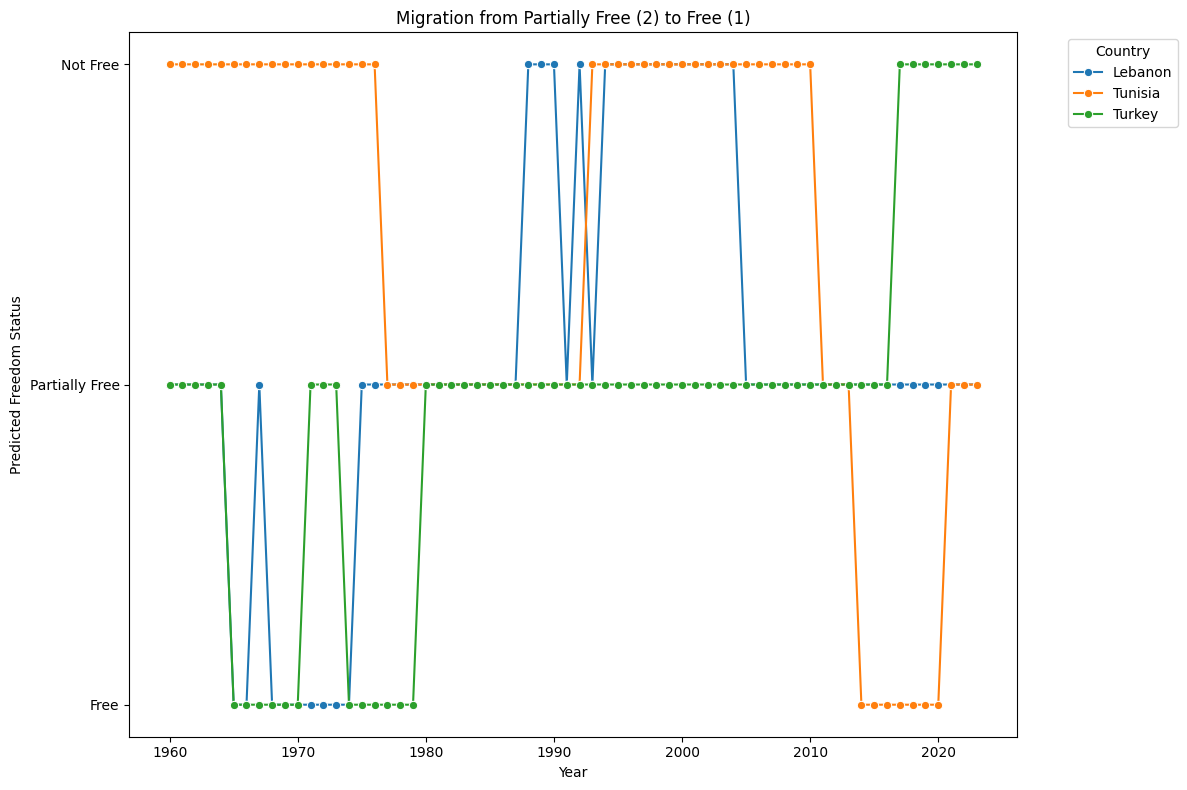


Countries that have ever migrated from Partially Free (2) to Free (1):
Lebanon
Tunisia
Turkey


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("mena_data.csv", low_memory=False)

# Assuming you have 'country_name', 'year', and 'pred_status' columns
# Convert 'year' to numeric (handle potential errors)
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df.dropna(subset=['year'], inplace=True)  # Remove rows with invalid years

# Sort by country and year for proper migration tracking
df.sort_values(by=['country_name', 'year'], inplace=True)

# Function to check for "2" to "1" migration
def has_migrated_to_free(group):
    # Check if 'pred_status' was 2 at any earlier year and 1 at any later year in the group
    was_partially_free = (group['pred_status'] == 2).any()
    became_free = (group['pred_status'] == 1).any()
    return was_partially_free and became_free

# Identify countries that have ever migrated from 2 to 1
migrated_countries = df.groupby('country_name').apply(has_migrated_to_free)
migrated_country_names = migrated_countries[migrated_countries].index.tolist()

# Filter the DataFrame to keep only the migrated countries
migrated_df = df[df['country_name'].isin(migrated_country_names)]

# Visualize the migration patterns
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='pred_status', hue='country_name', data=migrated_df, marker='o')
plt.title('Migration from Partially Free (2) to Free (1)')
plt.xlabel('Year')
plt.ylabel('Predicted Freedom Status')
plt.yticks([1, 2, 3], ['Free', 'Partially Free', 'Not Free'])
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()

# Print the list of countries that migrated
print("\nCountries that have ever migrated from Partially Free (2) to Free (1):")
for country in migrated_country_names:
    print(country)

<ipython-input-5-68f0f92924aa>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  migrated_to_free_countries = df.groupby('country_name').apply(has_migrated_to_free)
<ipython-input-5-68f0f92924aa>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  migrated_to_not_free_countries = df.groupby('country_name').apply(has_migrated_to_not_free)
<ipython-input-5-68f0f92924aa>:45: FutureWarning: Operation between non 

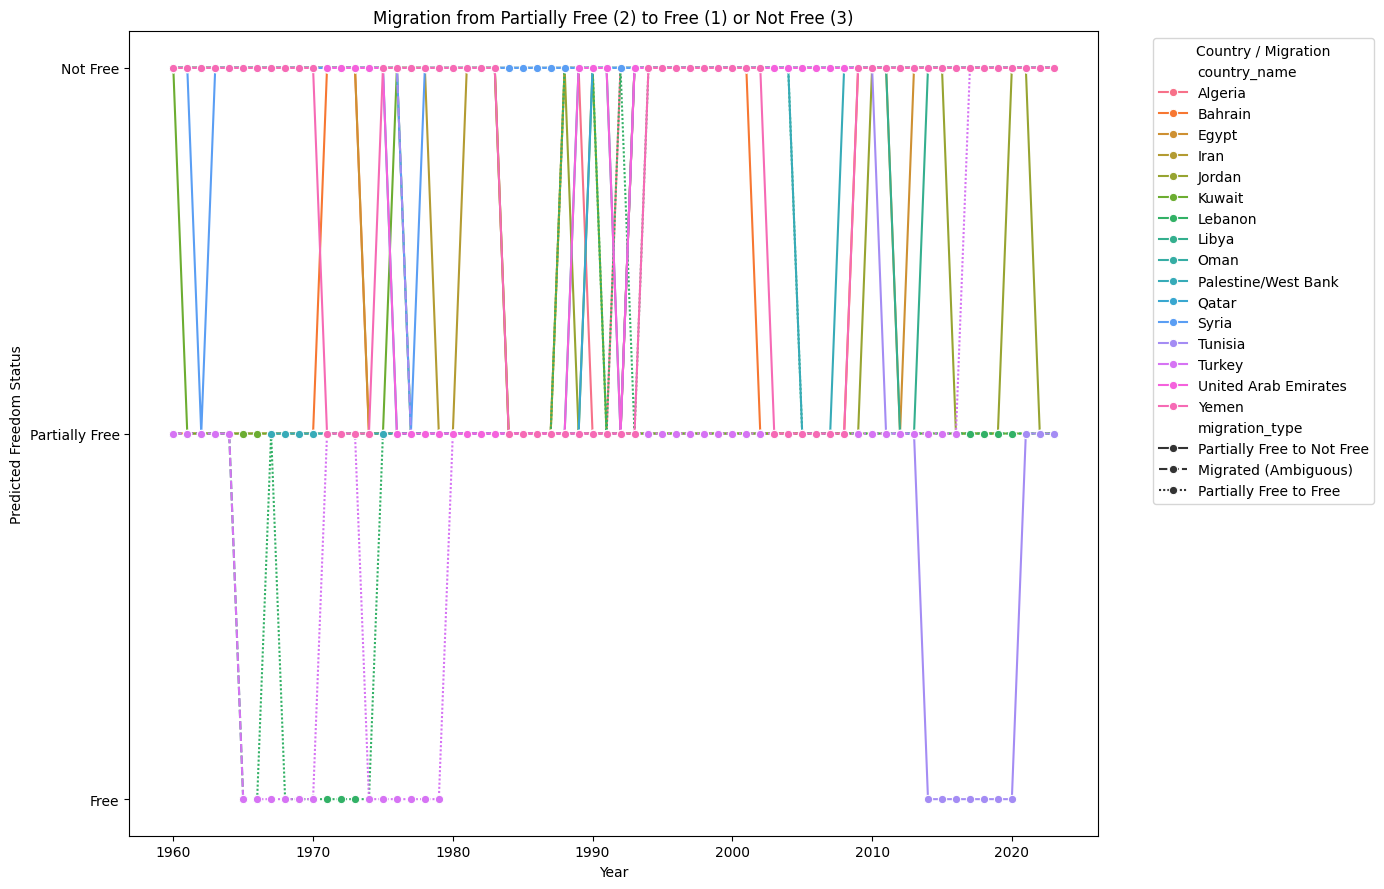


Countries that have ever migrated from Partially Free (2) to Free (1):
Lebanon
Tunisia
Turkey

Countries that have ever migrated from Partially Free (2) to Not Free (3):
Algeria
Bahrain
Egypt
Iran
Jordan
Kuwait
Lebanon
Libya
Oman
Palestine/West Bank
Qatar
Syria
Tunisia
Turkey
United Arab Emirates
Yemen

 Countries gone between both migration types:
Tunisia
Turkey
Lebanon


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("mena_data.csv", low_memory=False)

# Assuming you have 'country_name', 'year', and 'pred_status' columns
# Convert 'year' to numeric (handle potential errors)
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df.dropna(subset=['year'], inplace=True)  # Remove rows with invalid years

# Sort by country and year for proper migration tracking
df.sort_values(by=['country_name', 'year'], inplace=True)

# Function to check for "2" to "1" migration
def has_migrated_to_free(group):
    was_partially_free = (group['pred_status'] == 2).any()
    became_free = (group['pred_status'] == 1).any()
    return was_partially_free and became_free

# Function to check for "2" to "3" migration
def has_migrated_to_not_free(group):
    was_partially_free = (group['pred_status'] == 2).any()
    became_not_free = (group['pred_status'] == 3).any()
    return was_partially_free and became_not_free

# Identify countries that have ever migrated from 2 to 1
migrated_to_free_countries = df.groupby('country_name').apply(has_migrated_to_free)
migrated_to_free_names = migrated_to_free_countries[migrated_to_free_countries].index.tolist()

# Identify countries that have ever migrated from 2 to 3
migrated_to_not_free_countries = df.groupby('country_name').apply(has_migrated_to_not_free)
migrated_to_not_free_names = migrated_to_not_free_countries[migrated_to_not_free_countries].index.tolist()

# Filter the DataFrame for both migration types
migrated_df = df[df['country_name'].isin(migrated_to_free_names + migrated_to_not_free_names)]

# Add a new column to indicate the migration type for coloring
def get_migration_type(row):
    country = row['country_name']
    if country in migrated_to_free_names and country in migrated_to_not_free_names:
        # Handle cases where a country might have gone both ways (less common, adjust as needed)
        # Here, we prioritize the "to Not Free" as a potentially more concerning trend
        first_2_to_1_year = df[(df['country_name'] == country) & (df['pred_status'] == 1) & (df[df['year'] < row['year']].groupby('country_name')['pred_status'].transform(lambda x: (x == 2).any()))]['year'].min()
        first_2_to_3_year = df[(df['country_name'] == country) & (df['pred_status'] == 3) & (df[df['year'] < row['year']].groupby('country_name')['pred_status'].transform(lambda x: (x == 2).any()))]['year'].min()

        if pd.notna(first_2_to_3_year) and (pd.isna(first_2_to_1_year) or first_2_to_3_year < first_2_to_1_year):
            return 'Partially Free to Not Free'
        elif pd.notna(first_2_to_1_year):
            return 'Partially Free to Free'
        else:
            return 'Migrated (Ambiguous)' # Should ideally not happen
    elif country in migrated_to_free_names:
        return 'Partially Free to Free'
    elif country in migrated_to_not_free_names:
        return 'Partially Free to Not Free'
    return 'No Migration'

migrated_df['migration_type'] = migrated_df.apply(get_migration_type, axis=1)
migrated_df = migrated_df[migrated_df['migration_type'] != 'No Migration']

# Visualize the migration patterns
plt.figure(figsize=(14, 9))
sns.lineplot(x='year', y='pred_status', hue='country_name', style='migration_type', data=migrated_df, marker='o')
plt.title('Migration from Partially Free (2) to Free (1) or Not Free (3)')
plt.xlabel('Year')
plt.ylabel('Predicted Freedom Status')
plt.yticks([1, 2, 3], ['Free', 'Partially Free', 'Not Free'])
plt.legend(title='Country / Migration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print the lists of countries that migrated
print("\nCountries that have ever migrated from Partially Free (2) to Free (1):")
for country in migrated_to_free_names:
    print(country)

print("\nCountries that have ever migrated from Partially Free (2) to Not Free (3):")
for country in migrated_to_not_free_names:
    print(country)

print("\n Countries gone between both migration types:")
for country in set(migrated_to_free_names) & set(migrated_to_not_free_names):
    print(country)

<ipython-input-8-5cb6f00e2f60>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  migrated_to_free_countries = df.groupby('country_name').apply(has_migrated_to_free)
<ipython-input-8-5cb6f00e2f60>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  migrated_to_not_free_countries = df.groupby('country_name').apply(has_migrated_to_not_free)


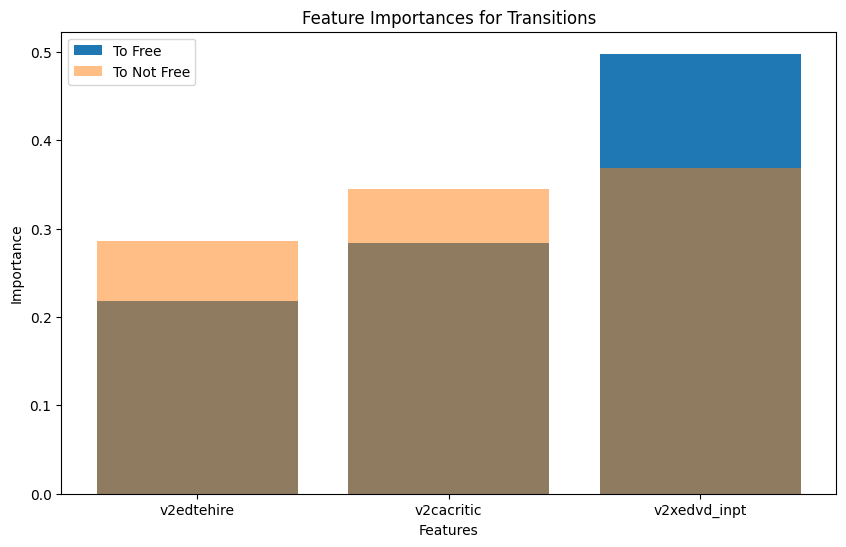

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


# Load the dataset
df = pd.read_csv("mena_data.csv", low_memory=False)

# Assuming you have 'country_name', 'year', and 'pred_status' columns
# Convert 'year' to numeric (handle potential errors)
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df.dropna(subset=['year'], inplace=True)  # Remove rows with invalid years

# Sort by country and year for proper migration tracking
df.sort_values(by=['country_name', 'year'], inplace=True)

# Function to check for "2" to "1" migration
def has_migrated_to_free(group):
    was_partially_free = (group['pred_status'] == 2).any()
    became_free = (group['pred_status'] == 1).any()
    return was_partially_free and became_free

# Function to check for "2" to "3" migration
def has_migrated_to_not_free(group):
    was_partially_free = (group['pred_status'] == 2).any()
    became_not_free = (group['pred_status'] == 3).any()
    return was_partially_free and became_not_free

# Identify countries that have ever migrated from 2 to 1
migrated_to_free_countries = df.groupby('country_name').apply(has_migrated_to_free)
migrated_to_free_names = migrated_to_free_countries[migrated_to_free_countries].index.tolist()

# Identify countries that have ever migrated from 2 to 3
migrated_to_not_free_countries = df.groupby('country_name').apply(has_migrated_to_not_free)
migrated_to_not_free_names = migrated_to_not_free_countries[migrated_to_not_free_countries].index.tolist()

# Create separate datasets
df_to_free = df[df['country_name'].isin(migrated_to_free_names)]
df_to_not_free = df[df['country_name'].isin(migrated_to_not_free_names)]
features_to_explore = ['v2edtehire', 'v2cacritic','v2xedvd_inpt'] # Replace with your actual feature names


# Example using Random Forest
X_free = df_to_free[features_to_explore]
y_free = df_to_free['pred_status'].shift(-1).apply(lambda x: 1 if x == 1 else 0)  # Target: Transition to Free next year?

model_free = RandomForestClassifier(random_state=42)
model_free.fit(X_free, y_free)


X_not_free = df_to_not_free[features_to_explore]
y_not_free = df_to_not_free['pred_status'].shift(-1).apply(lambda x: 1 if x == 3 else 0)  # Target: Transition to Not Free next year?

model_not_free = RandomForestClassifier(random_state=42)
model_not_free.fit(X_not_free, y_not_free)



importances_free = model_free.feature_importances_
importances_not_free = model_not_free.feature_importances_

# Example visualization
plt.figure(figsize=(10, 6))
plt.bar(features_to_explore, importances_free, label='To Free')
plt.bar(features_to_explore, importances_not_free, label='To Not Free', alpha=0.5)  # Overlay with transparency
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances for Transitions')
plt.legend()
plt.show()

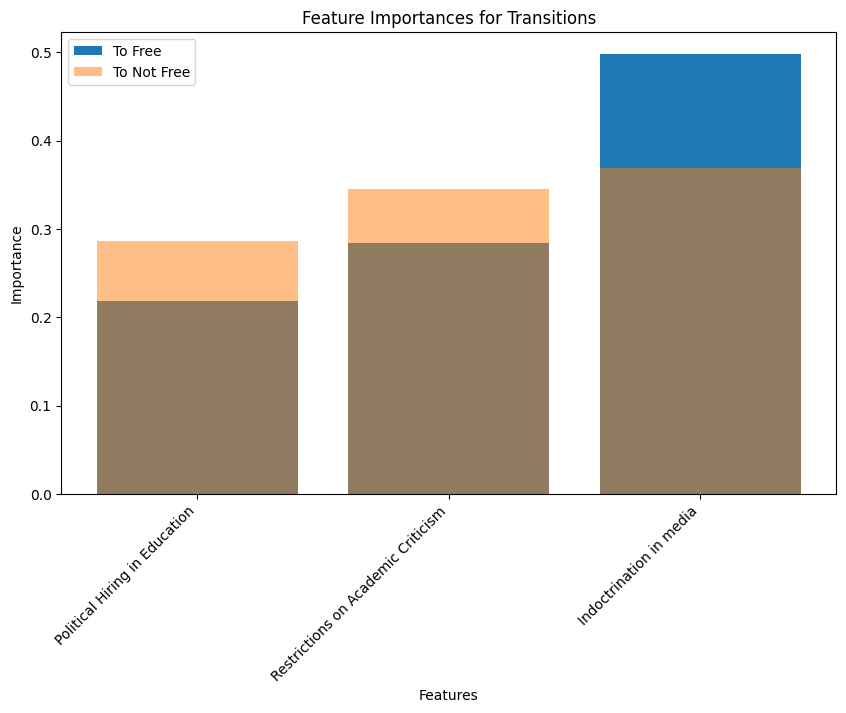

In [ ]:
new_feature_names = ['Political Hiring in Education', 'Restrictions on Academic Criticism', 'Indoctrination in media']
plt.figure(figsize=(15, 6))
plt.bar(new_feature_names, importances_free, label='To Free')  # Use new names here
plt.bar(new_feature_names, importances_not_free, label='To Not Free', alpha=0.5)  # Use new names here
plt.xticks(rotation=45, ha='right')  # Rotate for better readability if needed
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances for Transitions')
plt.legend()
plt.show()